<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [2]:
!pip install --user sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
trans_df = pd.read_csv('data/arhuaco/COMP.csv')
trans_df.rename(columns={"arh": "arhuaco"}, inplace = True)
print(trans_df.shape)
print(trans_df.columns)

(5735, 2)
Index(['esp', 'arhuaco'], dtype='object')


In [5]:
df_train, df_devtest = train_test_split(trans_df, test_size=2000, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=1000, random_state=42)

In [6]:
df_train.head()

,esp,arhuaco
356,asi que el senor dijo a abrahan la denuncia ...,niwipawri abraan ey keyri iku sodoma awiri...
1162,"y entonces, las siete vacas flacas y famelicas...","paka deyru deyru kawari, koga paka, chinchinte..."
4351,ellos contestaron unos dicen que eres juan e...,i'munu keywu nungwari jesuri a zun niwipawsin ...
5098,"unas tres horas mas tarde llego su mujer, que ...",ey anawi ingu maykunu ora nanukin zanise'ri an...
2042,"esten, pues, muy atentos porque no saben ni el...",ey uweri akin zari eymi zanunpuni miwe'zanu' g...


In [7]:
df_dev.head()

,esp,arhuaco
4949,pedro entonces le dijo no tengo plata ni oro...,pedruse' keywu key ie'ri jwi awiri oru nun...
4778,"y, como era de su mismo oficio, se alojo en su...",awi ase' nikamu uwagwi ikunha'se'ri winuwa nun...
3954,los apostoles no comprendian nada. no podian e...,jesuri powruba' jeriko aya muchey nikun nuse'r...
5375,estaban aun contemplando sin pestanear como se...,eymi anawi eykigwi jesu unzoyun wina'rizari ku...
5213,y nadie ha podido encontrarme enzarzado en dis...,"uwe'ki i'juna miwikeywa nungwa, niwitijoma zu ..."


In [8]:
df_test.head()

,esp,arhuaco
198,solo cuando ellos le repitieron palabra por pa...,ey uye'ki josese' winukuyaneyka yow akakuse' u...
1281,"a jobab lo sucedio jusan, natural de teman",ey awi jobab unwicha anuye'ri a unde'gukuya ka...
4256,en aquel momento se les abrieron los ojos y lo...,uye' nungwari ikunha'ri takuchu nungwa a i...
903,"hijos de bilha, la criada de raquel dan y nef...",bilha rakeri zu gunamuse' kugosanari dan awiri...
411,pero jose rehuso diciendo a la mujer de su amo...,josese'ri eymi kuyana nupaw kinkiri inu az...


# 2. How well does the data fit into a NLLB tokenizer?

In [9]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [10]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')

In [11]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [12]:
smpl = df_train.sample(10000, random_state=42, replace=True)

smpl['esp_toks'] = smpl.esp.apply(tokenizer.tokenize)
smpl['arhuaco_toks'] = smpl.arhuaco.apply(tokenizer.tokenize)

smpl['esp_words'] = smpl.esp.apply(word_tokenize)
smpl['arhuaco_words'] = smpl.arhuaco.apply(word_tokenize)

In [13]:
smpl.sample(5)[['esp', 'esp_words', 'esp_toks', 'arhuaco', 'arhuaco_words', 'arhuaco_toks']]

,esp,esp_words,esp_toks,arhuaco,arhuaco_words,arhuaco_toks
3444,y la gente decia llena de asombro este lo ha...,"[y, la, gente, decia, llena, de, asombro, este...","[▁y, ▁la, ▁gente, ▁de, cia, ▁ll, ena, ▁de, ▁as...","ey uye'ri e'gwi kukwa'ri kutikena awiri, kori'...","[ey, uye, ', ri, e, ', gwi, kukwa, ', ri, kuti...","[▁ey, ▁uye, ', ri, ▁e, ', g, wi, ▁kuk, wa, ', ..."
3202,jesus ordeno severamente que no hicieran saber...,"[jesus, ordeno, severamente, que, no, hicieran...","[▁j, esus, ▁orden, o, ▁sever, amente, ▁que, ▁n...",uye'ri e' kingwi gaysinusita i'ngwi uga mowga ...,"[uye, ', ri, e, ', kingwi, gaysinusita, i, ', ...","[▁uye, ', ri, ▁e, ', ▁king, wi, ▁gay, sin, usi..."
2734,increpandolos esto dicen las escrituras mi ...,"[increpandolos, esto, dicen, las, escrituras, ...","[▁inc, rep, and, olos, ▁esto, ▁dicen, ▁las, ▁e...","niwipaw zu ga'kunamu duna a'nikwuya'bari, nun...","[niwipaw, zu, ga, ', kunamu, duna, a, ', nikwu...","[▁ni, wi, paw, ▁zu, ▁ga, ', kun, amu, ▁duna, ▁..."
4079,no encontrando el modo de introducirlo a causa...,"[no, encontrando, el, modo, de, introducirlo, ...","[▁no, ▁encontr, ando, ▁el, ▁modo, ▁de, ▁introd...",ey uye' nungwa ingu mowga cheyrwa rinari keywu...,"[ey, uye, ', nungwa, ingu, mowga, cheyrwa, rin...","[▁ey, ▁uye, ', ▁nung, wa, ▁ingu, ▁mo, w, ga, ▁..."
3163,muchas veces lo habian encadenado y sujetado c...,"[muchas, veces, lo, habian, encadenado, y, suj...","[▁muchas, ▁veces, ▁lo, ▁ha, bian, ▁enc, aden, ...","ema cheyrwari ka' unkumuyunke zun kweyri, bema...","[ema, cheyrwari, ka, ', unkumuyunke, zun, kwey...","[▁ema, ▁che, yr, wari, ▁ka, ', ▁un, k, umu, yu..."


In [14]:
stats = smpl[['esp_toks', 'arhuaco_toks', 'esp_words', 'arhuaco_words']].applymap(len).describe()
stats

,esp_toks,arhuaco_toks,esp_words,arhuaco_words
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,31.624800,53.816700,24.801600,33.676000
std,14.833591,25.826324,11.645694,16.416156
min,1.000000,0.000000,1.000000,0.000000
25%,22.000000,37.000000,17.000000,23.000000
50%,30.000000,51.000000,23.000000,32.000000
75%,39.000000,66.000000,31.000000,42.000000
max,420.000000,508.000000,312.000000,348.000000


In [15]:
print(stats.esp_toks['mean'] / stats.esp_words['mean'])
print(stats.arhuaco_toks['mean'] / stats.arhuaco_words['mean'])

1.275111283143023
1.5980728114978024


In [16]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for arhuaco? If this is too often, we need to fix it somehow</p>

In [17]:
texts_with_unk = [text for text in tqdm(trans_df.arhuaco) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/5735 [00:00<?, ?it/s]

0


<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Adding a new language tag to the tokenizer and model</h1>

In [18]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [19]:
tokenizer = NllbTokenizer.from_pretrained('facebook/nllb-200-distilled-600M')
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202, 256203]))

256204
['zul_Latn', '<mask>']


In [20]:
def fix_tokenizer(tokenizer, new_lang='arhuaco_Cyrl'):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [21]:
fix_tokenizer(tokenizer)

In [22]:
print(tokenizer.convert_ids_to_tokens([256202, 256203, 256204])) # ['zul_Latn', 'arhuaco_Cyrl', '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', 'arhuaco_Cyrl', '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'arhuaco_Cyrl', '<mask>']
[256202, 256203, 256204]


In [23]:
added_token_id = tokenizer.convert_tokens_to_ids('arhuaco_Cyrl')
similar_lang_id = tokenizer.convert_tokens_to_ids('kir_Cyrl')
print(added_token_id, similar_lang_id)

256203 256095


In [24]:
model = AutoModelForSeq2SeqLM.from_pretrained('facebook/nllb-200-distilled-600M')
model.resize_token_embeddings(len(tokenizer))

Embedding(256205, 1024)

In [25]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">4. Preparing the training loop</h1>

In [26]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [27]:
model.cuda();

In [28]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [29]:
batch_size = 8  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1_000
training_steps = 57000

In [30]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [31]:
LANGS = [('esp', 'spa_Latn'), ('arhuaco', 'arhuaco_Cyrl')]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(item[l1])
        yy.append(item[l2])
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(["zabulondi jiwu okunun,barku nugwenukwey zuna'ba kweyri,ka'gumuri sidon muchey kinkumukin kure'nikungwa ni."], ['zabulon habita junto al mar,servira de puerto a los barcos,sus fronteras llegaran hasta sidon.'], 'arhuaco_Cyrl', 'spa_Latn')


In [32]:
MODEL_SAVE_PATH = 'models/nllb_arhuaco_COMP-v1'

<h1 id="6.-The-training-loop">5. The training loop</h1>

In [33]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 4.6762003898620605
1000 4.217631695508957
2000 3.013664637327194
3000 2.5630907510519028
4000 2.2504800854921343
5000 1.9669541858434678
6000 1.712685430407524
7000 1.4678809213638306
8000 1.3001491672992707
9000 1.116504607349634
10000 0.9427643909603357
11000 0.8012685672044754
12000 0.6948073609918356
13000 0.5726550854444504
14000 0.483925300270319
15000 0.4065847760885954
16000 0.3412712204605341
17000 0.2912711558453739
18000 0.25184310184046627
19000 0.21520624690130352
20000 0.18716962487250566
21000 0.15786210587248206
22000 0.14552178223803638
23000 0.12523095084168018
24000 0.11529159204289317
25000 0.10603194163925946
26000 0.09830942457169295
27000 0.08893148952908814
28000 0.08474354507867247
29000 0.07804185663443058
30000 0.07309187855012715
31000 0.0679630464464426
32000 0.06534665801795199
33000 0.06524790684133767
34000 0.06012481678556651
35000 0.058344713448546824
36000 0.05516399431414902
37000 0.05202743093157187
38000 0.05033017924334854
39000 0.04790156842884

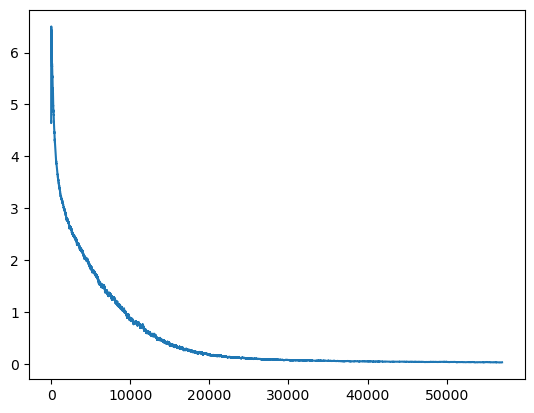

In [34]:
pd.Series(losses).ewm(100).mean().plot();

In [35]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [36]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['ellos, al ver que los llevaban a casa de jose, se asustaron, pues pensaban   nos han traido aqui a causa del dinero que devolvieron en nuestros costales la vez pasada. esto es un pretexto para acusarnos, condenarnos, hacernos esclavos y quedarse con nuestros asnos.']
["josesin winunkuya jinari, jose zun urakaku winnunhawazwein nugin wina'zare'ri chowchu winukunasi nungwa eymi winunkuyana     sanusi sakuse' jwi niwekupunnachuka gunamu nari burusin nenun nisi zasanun niwicho'kumungwa nari niwinhawazori nanu'kinunno  winunkuyana."]
["ikunha'ri, josese' urakuse' unwinkinkumaye'ri chowchu gun winukunasi, jwi unme'zasana awaki nugin, eygwi sumukuchu unmiwika'siri, besun niwinhuzoya, buru ungaria awiri, yow unsin kusa anukungwa ni kuyundi a'zariwin kuyundi winukey ie'ri."]


In [37]:
!ls -alsh $MODEL_SAVE_PATH

total 2.3G
4.0K drwxr-xr-x  2 jovyan users 4.0K Nov 26 19:45 .
4.0K drwxr-xr-x 11 jovyan users 4.0K Nov 26 19:45 ..
4.0K -rw-r--r--  1 jovyan users  896 Nov 27 01:29 config.json
4.0K -rw-r--r--  1 jovyan users  184 Nov 27 01:29 generation_config.json
2.3G -rw-r--r--  1 jovyan users 2.3G Nov 27 01:29 pytorch_model.bin
4.7M -rw-r--r--  1 jovyan users 4.7M Nov 27 01:29 sentencepiece.bpe.model
4.0K -rw-r--r--  1 jovyan users 3.5K Nov 27 01:29 special_tokens_map.json
4.0K -rw-r--r--  1 jovyan users  570 Nov 27 01:29 tokenizer_config.json


<h1 id="6.-Using-the-model">6. Testing the model</h1>

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [39]:
def fix_tokenizer(tokenizer, new_lang='arhuaco_Cyrl'):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [40]:
model_load_name = 'models/nllb_arhuaco_COMP-v1'
model = AutoModelForSeq2SeqLM.from_pretrained(model_load_name).cuda()
tokenizer = NllbTokenizer.from_pretrained(model_load_name)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [41]:
def translate(text, src_lang='spa_Latn', tgt_lang='eng_Latn', a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [42]:
t = "Hola como estas, ya hiciste la tarea de hoy"
print(translate(t, 'spa_Latn', 'arhuaco_Cyrl'))

["mari du nunhure'bonungwari, iwa nungunamusow nikamu a'we ukumanige'ri"]


In [43]:
translate(t, 'spa_Latn', 'arhuaco_Cyrl', do_sample=True, num_beams=1, temperature=1.5)

["migutana awundi i'muresari mika'nayari mikunayari miwinhipunhasa uni'kwe"]

In [44]:
def batched_translate(texts, batch_size=16, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [45]:
esp_translated = batched_translate(df_test.esp, src_lang='spa_Latn', tgt_lang='arhuaco_Cyrl')

  0%|          | 0/63 [00:00<?, ?it/s]

In [46]:
df_test['esp_translated'] = [translate(t, 'arhuaco_Cyrl', 'spa_Latn')[0] for t in tqdm(df_test.arhuaco)]
df_test['arhuaco_translated'] = [translate(t, 'spa_Latn', 'arhuaco_Cyrl')[0] for t in tqdm(df_test.esp)]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [47]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [48]:
print(bleu_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(chrf_calc.corpus_score(df_test['esp_translated'].tolist(), [df_test['esp'].tolist()]))
print(bleu_calc.corpus_score(df_test['arhuaco_translated'].tolist(), [df_test['arhuaco'].tolist()]))
print(chrf_calc.corpus_score(df_test['arhuaco_translated'].tolist(), [df_test['arhuaco'].tolist()]))

BLEU = 7.28 30.1/7.9/4.2/2.8 (BP = 1.000 ratio = 1.000 hyp_len = 25208 ref_len = 25210)
chrF2++ = 24.94
BLEU = 5.77 25.9/7.7/3.6/2.1 (BP = 0.929 ratio = 0.931 hyp_len = 22359 ref_len = 24016)
chrF2++ = 29.87


In [49]:
pd.options.display.max_colwidth = 100

In [50]:
df_test.sample(10, random_state=42)[['arhuaco', 'esp', 'arhuaco_translated', 'esp_translated']]

,arhuaco,esp,arhuaco_translated,esp_translated
3181,"ey anawi jesuri i'munu eygwi aykwarigun barkusin unkinkumey jiwu okunun unnare'ri, i'munu eygwi ...","entonces llego uno de los jefes de la sinagoga, llamado jairo, que, al ver a jesus, se postro a ...","ey uye' nungwari i'ngwi jairu za'kinuga, sinagogase' umun a'zuna nunna. jairuri jesu ni a'zari g...","cuando de pronto se acercaron a jesus, se acercaron a el muchos que estaban admirados por su par..."
4016,uye' nungwari guna' tonajuri gaysinu amuse kuyana.,"jesus, tomandola de la mano, exclamo muchacha, levantate","gaysinusita i'ngwi uga mowga kutow kugi' izariri, gumusinu umun a'zuna zu gunamu warinzanuri tun...","jesus se levanto, tomo la palabra y le dijo quiero. queda limpio."
5573,"ey awi pabluri eymi ie'ri, sadusew jina nari farisew jinasindi, ikunha gunti winunka'nugwe wina'...",y par. flp,ey uye' keywu a'mia jinari jesuse' eymi winukuyaneykari winugunchunna.,"pablo tomo la palabra y se dirigio a un grupo de saduceos y fariseos que, formando un grupo de r..."
2118,"karga mu a'zunari uzweykwey nanu' neyka, ajwase' uzweingwa wina'zari ey winye'ki, ikunha'se' nun...",todo lo hacen para que la gente los vea. usan filacterias mas anchas y flecos mas largos que nin...,"miwise'ri ikuse' winchwungwa nari gunti, pinnase' achusana na'me, pinnase' achusana gun nundi.","esperaban el impuesto, pero era evidente que el lo rechazaba."
110,"santafe de bogotd, febrero de NUM",s,"ey une'ki pin a'nikwayukin ikun ankazagikumu' nari, ingumin niwika'mukanukwey neykaagaguka ukuma...","santa fe de bogotd, febrero de NUM"
2916,"eymeku keywu jesuse' winukey ie'ri miwiri yow unnuchukuma awungwa na'nunno, sanusi niwipaw z...",pero despues de mi resurreccion ire delante de ustedes a galilea.,"uweki eygwi chuka unna'zanika unige'ri, miwe'sanusi galilea zwein nukunungwa gun neri winukey ie...","jesus les dijo por eso, ustedes me abandonaran, porque asi lo dicen las escrituras herire al pas..."
1392,"ey anunaju nungwa israerise' keywu key ie'ri ta kinki, iwa nungwa eyki nukuyun unna'zun gun ...",entonces israel dijo a jose ahora ya puedo morir. te he visto y se que estas vivo.,"ey awi jose eygwi key ie'ri unwichukwa gun nukawundi, unwichukwa neki unnanu' gun nare'ri.","entonces israel replico seguro que he visto esto, y por eso lo he guardado bien."
68,"ga'kunama abunna zukutu du unde'bonungwa nari, santa fe de bogote unnikumeyazoyanari wya anukuc...",al clausurar las sesiones de la asamblea nacional constituyente afirme que ese dia seiniciaba un...,"nabusimuke, febrero timase' NUM kugise'.","fue entonces, cuando los habitantes de cesarea se enteraron de que el templo estaba construido. ..."
1192,"iwa nanu' nundi faraonse'ri, gowernador neki zuguro jwa rekusiri, zuneku egiptu meyna zamu a'suy...","que establezca tambien gobernadores por todo el pais, encargados de recaudar la quinta parte de ...","ey awi ikunha'ri pin egiptu meyna, koga kugi' zanukindi, i'ngwi uga mowga kutow egiptu zamu umun...","el faraon envio a dos de sus cortesanos egipcios, cada uno a su cargo, y cargo con sus provisiones."
3706,"inuri niwipawse'ri chuwi kaniga'me,gun ku'nawarigun pariri jwi a'chuna zana' nisi niwisakuku niw...","en cuanto a ti, hijo mio,seras profeta del dios altisimo,porque iras delante del senorpara prepa...","ma migumusinu mazey profeta unige'ri,i'ngwi pinna inu kwey awun nuga gwasi umun awunkawa kukusir...","porque les digo que, si alguno dice a su padre o a su madre lo que tenia reservado para ayudarte..."
